# PCA and Best Transform

This algorithm find optimal rigid transformation of a point cloud by using Principal Component Analysis. 
Principal component analysis (PCA) is useful for data compression and classification. The goal is to reduce the dimensionality of a data set (sample) by identifying a new collection of variables that is smaller than the original set but still preserves the majority of the information in the sample. The new variables, known as principal components (PCs), are uncorrelated and are ranked according to how much of the total information they retain.

## Config

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

NUM_POINTS = 1000
ROTATION = np.deg2rad(29.0)
SCALE = np.asarray([10.0, 5.0])
TRANSLATE = np.asarray([2.5, 1])

## Create Data

First, we allocate a matrix $X \in \mathbb{R}^{m \times n} $ where each row is a two dimensional point in space. $m$ is the number of points (observation) and $n=2$ which is the number of dimensions.

$$X = \begin{bmatrix}
x_0 & y_0\\ 
x_1 & y_1\\ 
\dots & \dots\\ 
x_n & y_n 
\end{bmatrix}$$

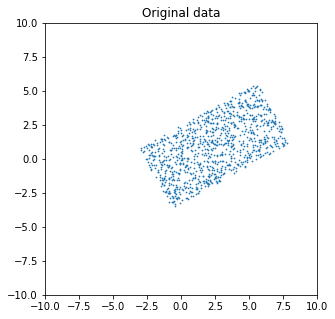

The matrix X shape is (1000, 2)


In [ ]:
def random_points():
    # Creates samples into a [(-1,-1), (1,1)] box
    points = np.random.rand(NUM_POINTS, 2) - 0.5
    cos_angle = np.cos(ROTATION)
    sin_angle = np.sin(ROTATION)
    transform = np.asarray([[cos_angle * SCALE[0],  -sin_angle * SCALE[1]],
                            [sin_angle * SCALE[0],  cos_angle * SCALE[1]]])
    
    points = np.matmul(points, transform.T)
    points += TRANSLATE
    return points

X = random_points()

# Draw points
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title('Original data')
ax.set_aspect('equal')
x, y = zip(*X)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
ax.scatter(x, y,s=0.5)
plt.show()

# Print matrix shape
print('The matrix X shape is {}'.format(X.shape))

## Principal Component Analysis (PCA)

Use the Principal component analysis (PCA) to find the best rotation.
PCA tries to maximize the variance for each component directions.

1. Prepare data : Zero-meaned
2. Covariance Matrix
3. Eigen Decomposition
4. Project original data on Principal components

### 1. Prepare Data : Zero Mean

Transform the data $X$ to zero-meaned data $X_{c}$ by subtracting the mean of each dimension.

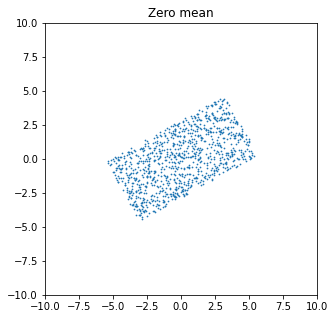

In [ ]:
# Set the mean of the data to zero
X_c = np.copy(X)
mean = np.mean(X, axis=0)
X_c -= mean

# Draw points
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Zero mean')
ax.set_aspect('equal')
x, y = zip(*X_c)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
ax.scatter(x, y,s=0.5)
plt.show()

### 2. Covariance Matrix

The covariance matrix $C \in \mathbb{R}^{n \times n} $, where $n$ is the number of dimensions :

$$C = \begin{bmatrix}
Cov(x,x) & Cov(x,y) \\ 
Cov(y,x) & Cov(y,y)
\end{bmatrix}$$

The covariance $Cov(x,x)$ for a Zero-meaned data is :

$$
Cov(x, y) = \frac{(x \cdot y)}{n}
$$

The covariance matrix can be rewritten as :

$$
C = \frac{{X_{c}}^T X_{c}}{n}
$$

In [ ]:
# Covariance matrix
C = np.dot(X_c.T, X_c) / NUM_POINTS
print('The covariance matrix shape is {}'.format(C.shape))

The covariance matrix shape is (2, 2)


### 3. Eigen Decomposition

The covariance matrix is $𝐶$, The eigenvectors $\left \{ v_{1}, \cdots , v_{n} \right \}$ and eigenvalues $\left \{ \lambda_{1}, \cdots , \lambda_{n} \right \}$ are the set of vectors/values such that $C v_{i} = \lambda_{i} v_{i}$. The eigenvectors are orthogonal because the covariance matrix is symmetric.
The eigenvectors correspond to the principal components and the eigenvalues correspond to the variance explained by the principal components.

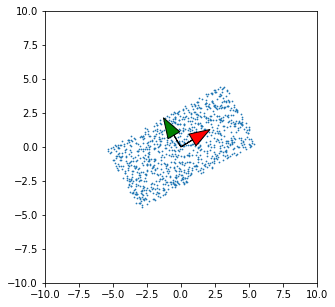

In [ ]:
# Covariance decomposition
w, v = np.linalg.eig(C)

# Create rotation matrix
rotation_matrix = v
det = np.linalg.det(rotation_matrix)
if det < 0.0:
    # from reflection matrix to rotation matrix
    rotation_matrix *= -1.0

# Visualize points and eigen vectors
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
x, y = zip(*X_c)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
ax.scatter(x, y,s=0.5)
eigvec0 = rotation_matrix[:,0]
eigvec1 = rotation_matrix[:,1]
ax.arrow(0, 0, eigvec0[0], eigvec0[1], head_width=1.0, facecolor='red', edgecolor='black')
ax.arrow(0, 0, eigvec1[0], eigvec1[1], head_width=1.0, facecolor='green', edgecolor='black')
plt.show()

### 4. Project data

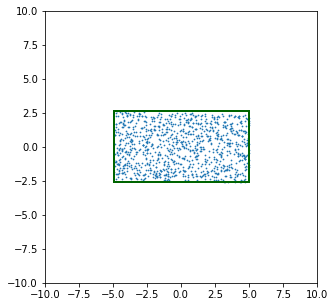

In [ ]:
# Transform from world space to local space
inverse_matrix = rotation_matrix.T
project_X = np.copy(X)
project_X -= mean
project_X = np.matmul(project_X, inverse_matrix.T)

# Compute local bounding box
box_min = np.min(project_X, axis=0)
box_max = np.max(project_X, axis=0)

# Visualize points and bounding box
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
x, y = zip(*project_X)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
ax.scatter(x, y,s=0.5)
vertex = np.asarray([(box_min[0], box_min[1]), (box_min[0], box_max[1]),
                     (box_max[0], box_max[1]), (box_max[0], box_min[1])])
polygon = patches.Polygon(vertex, closed=True,ec='darkgreen',lw=2,fill=False)
ax.add_patch(polygon)
plt.show()

## Evaluation

We have the new bases and we can transform 

### 1. Prediction

Transform the points back to world space by using the mean (for translation) and the eigen vectors (for rotation)

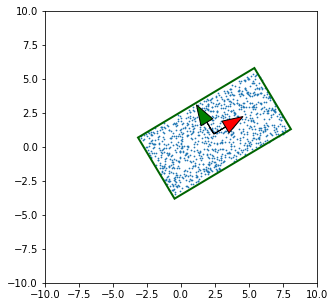

In [ ]:
# Transform from local space to world space
predict_X = np.copy(project_X)
predict_X = np.matmul(project_X, rotation_matrix.T)
predict_X += mean

# Visualize points and bounding box
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
x, y = zip(*predict_X)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
ax.scatter(x, y,s=0.5)
predict_aabb = np.asarray([(box_min[0], box_min[1]), (box_min[0], box_max[1]),
                     (box_max[0], box_max[1]), (box_max[0], box_min[1])])
predict_aabb = np.matmul(vertex, rotation_matrix.T)
predict_aabb += mean

polygon = patches.Polygon(predict_aabb, closed=True,ec='darkgreen',lw=2,fill=False)
ax.add_patch(polygon)
eigvec0 = rotation_matrix[:,0]
eigvec1 = rotation_matrix[:,1]
ax.arrow(mean[0], mean[1], eigvec0[0], eigvec0[1], head_width=1.0, facecolor='red', edgecolor='black')
ax.arrow(mean[0], mean[1], eigvec1[0], eigvec1[1], head_width=1.0, facecolor='green', edgecolor='black')
plt.show()

### 2. Reconstruction Errors

In [ ]:
# Compute the difference from original data
diff = predict_X - X
errors = np.linalg.norm(diff, axis=1)
print('The largest erros in the reconstruction is {} '.format(np.max(errors)))

The largest erros in the reconstruction is 2.5121479338940403e-15 
